<a href="https://colab.research.google.com/github/Nandakishor999/FMML_MODULE/blob/main/Module_7_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 7 Project: Movie Recommendation Engine

`Module Coordinator: Ganesh Chandan`

In this module, we will try to create a Movie Recommendation System using different unsupervised learning techniques.

In [1]:
# dataset download

# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2025-03-11 08:15:04--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   764KB/s    in 1.3s    

2025-03-11 08:15:06 (764 KB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Clustering based recommendation

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [6]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In order to have a more delimited subset of people to study, we are going to bias our grouping to only get ratings from those users that like either romance or science fiction movies.

In [7]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


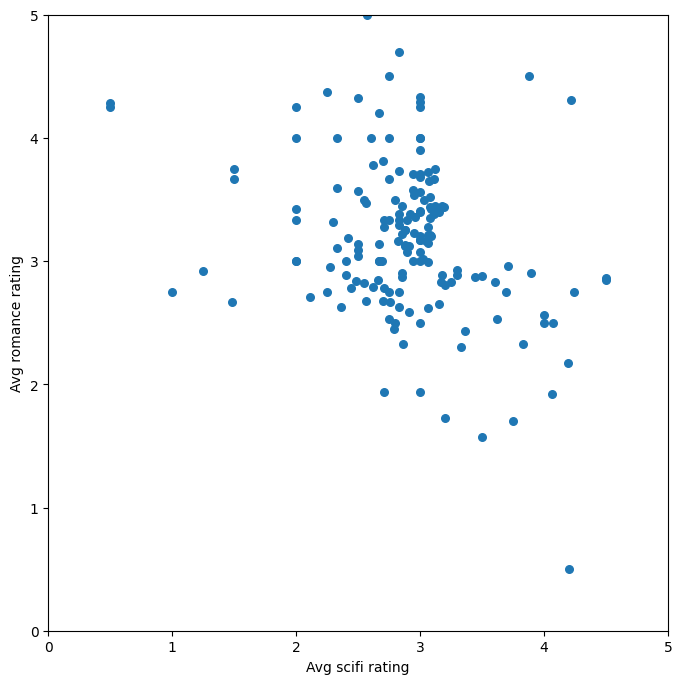

In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

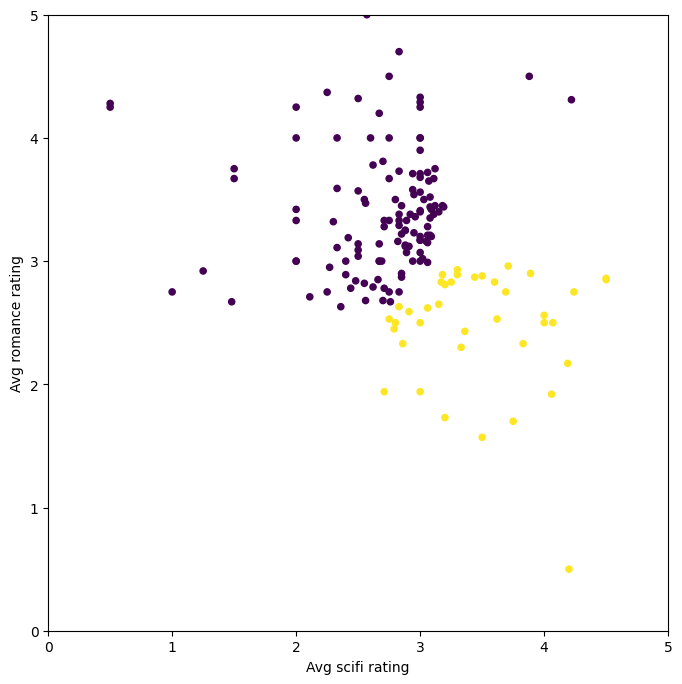

In [9]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

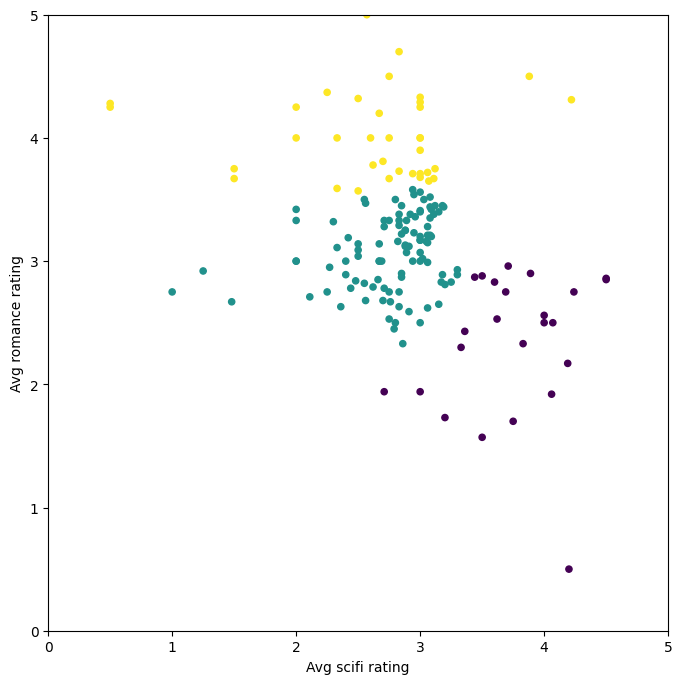

In [10]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

It is evident now that the science-fiction rating has started to come into play:

    People who like sci-fi and romance modeately belong to the green group.
    People who like scifi but not romance belong to the yello group.
    People who like romance but not sci-fi belong to the purple group.

Finding optimal clusters using silhouette score

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


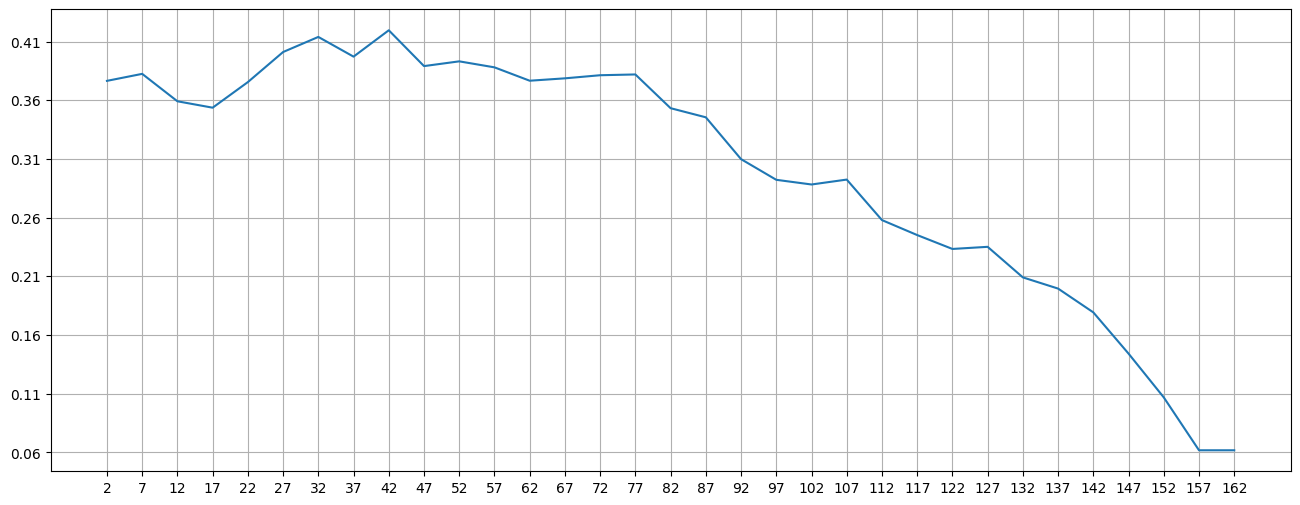

In [11]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

We will chose the K = 7 as it is the one that yields the best score and will be easier to visualize.



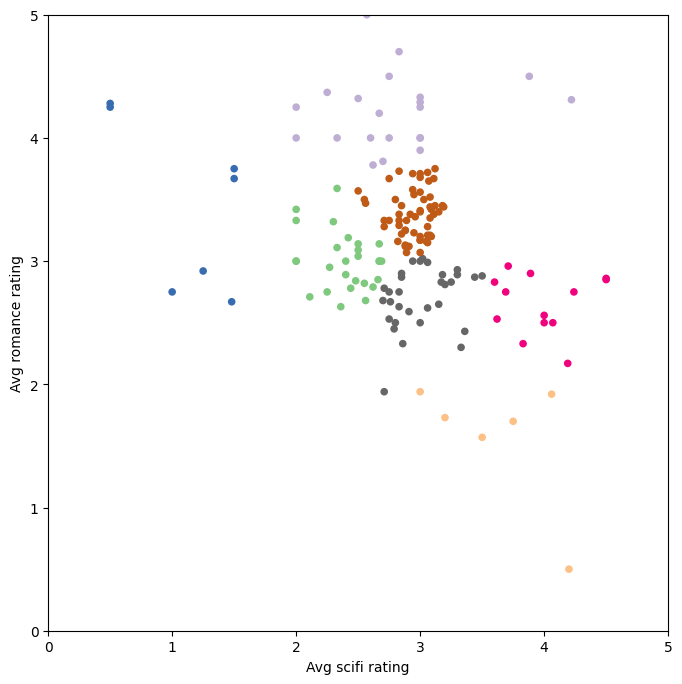

In [12]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Up to now, we have only analyzed romance and science-fiction movies. Let us see what happens when adding other genre to our analysis by adding Action movies.

In [13]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


In [14]:
# prompt: Using dataframe biased_dataset_3_genres: generate  code

import pandas as pd
import numpy as np

# create synthetic data for demonstration purposes
np.random.seed(42)
data = {
    'index': range(1, 162),
    'avg_romance_rating': np.random.uniform(0.5, 5, 161),
    'avg_scifi_rating': np.random.uniform(0.5, 4.5, 161),
    'avg_action_rating': np.random.uniform(0.93, 4.64, 161)
}

biased_dataset_3_genres = pd.DataFrame(data)

# Calculate the mean of each rating column
mean_romance_rating = biased_dataset_3_genres['avg_romance_rating'].mean()
mean_scifi_rating = biased_dataset_3_genres['avg_scifi_rating'].mean()
mean_action_rating = biased_dataset_3_genres['avg_action_rating'].mean()

print(f"Mean Romance Rating: {mean_romance_rating}")
print(f"Mean Sci-Fi Rating: {mean_scifi_rating}")
print(f"Mean Action Rating: {mean_action_rating}")

# Calculate standard deviations of each rating column
std_romance_rating = biased_dataset_3_genres['avg_romance_rating'].std()
std_scifi_rating = biased_dataset_3_genres['avg_scifi_rating'].std()
std_action_rating = biased_dataset_3_genres['avg_action_rating'].std()

print(f"Standard Deviation Romance Rating: {std_romance_rating}")
print(f"Standard Deviation Sci-Fi Rating: {std_scifi_rating}")
print(f"Standard Deviation Action Rating: {std_action_rating}")


Mean Romance Rating: 2.644077924684713
Mean Sci-Fi Rating: 2.5499251512103527
Mean Action Rating: 2.7919262101890494
Standard Deviation Romance Rating: 1.332177388405438
Standard Deviation Sci-Fi Rating: 1.1645548446195297
Standard Deviation Action Rating: 1.143246649821204


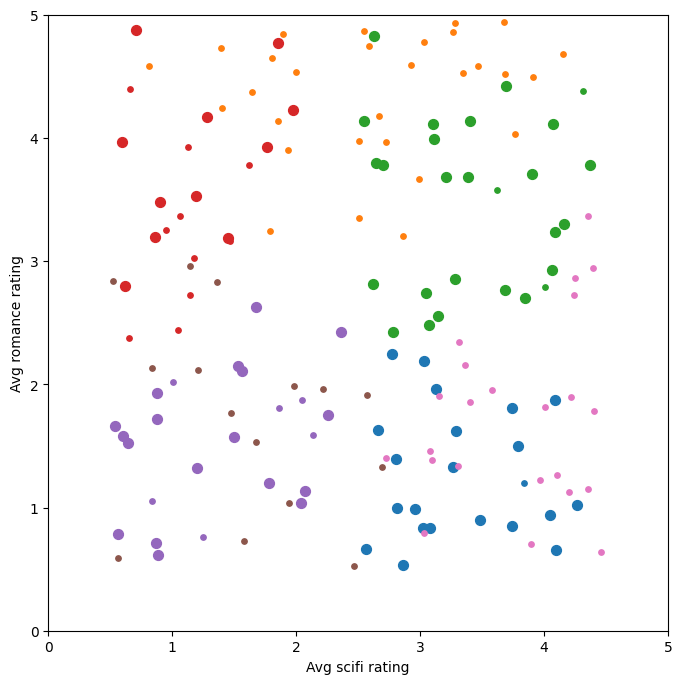

In [15]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

The size of the dots represent the ratings of the action movies.

# Exercise 1

## Instead of choosing a n_clusters as 7, play around with different k
## Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method

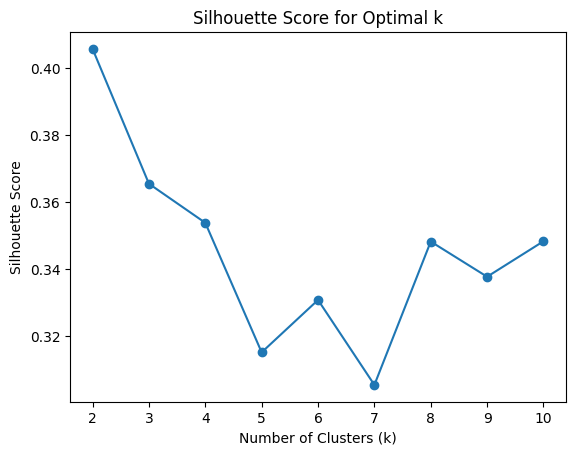

In [16]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Drop rows with NaN values
genre_ratings_cleaned = genre_ratings.dropna()

k_range = range(2, 11)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(genre_ratings_cleaned)
    score = silhouette_score(genre_ratings_cleaned, cluster_labels)
    silhouette_scores.append(score)

plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [17]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Define Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    count_row = user_movie_ratings.count().to_frame().T  # Convert the count series to a DataFrame
    user_movie_ratings = pd.concat([user_movie_ratings, count_row], ignore_index=True)

    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)

    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies


In [23]:
from itertools import combinations

# Sample list
items = [1, 2, 3, 4]

# Generate all 2-element combinations
comb = list(combinations(items, 2))
print(comb)  # Output: [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


In [24]:
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000).replace(np.nan, 0)

In [25]:
from scipy import sparse

# Conversion to sparse csr matrix
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

### Large Scale Clustering

In [26]:
from sklearn.cluster import KMeans

# 20 clusters with a valid algorithm ('elkan' or 'lloyd')
predictions = KMeans(n_clusters=20, algorithm='lloyd').fit_predict(sparse_ratings)


### Predictions and Recommendation

In [29]:
import pandas as pd

def sort_by_rating_density(ratings, n_movies, n_users):
    """
    Filters and sorts the given user-movie ratings dataframe by rating density.

    Args:
    ratings (pd.DataFrame): User-movie ratings matrix.
    n_movies (int): Number of top-rated movies to keep.
    n_users (int): Number of top users to keep.

    Returns:
    pd.DataFrame: Filtered user-movie matrix with high-density ratings.
    """
    # Select top movies with most ratings
    most_rated_movies = ratings.notna().sum().sort_values(ascending=False).head(n_movies).index

    # Select top users who have rated the most movies
    most_active_users = ratings.loc[:, most_rated_movies].notna().sum(axis=1).sort_values(ascending=False).head(n_users).index

    # Filter dataframe
    filtered_ratings = ratings.loc[most_active_users, most_rated_movies]

    return filtered_ratings


In [31]:
# Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Matrix, The (1999)"
cluster[movie_name].mean()

4.833333333333333

In [32]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

,0
Forrest Gump (1994),4.000000
"Shawshank Redemption, The (1994)",4.500000
Pulp Fiction (1994),4.000000
"Silence of the Lambs, The (1991)",4.500000
"Matrix, The (1999)",4.833333
Star Wars: Episode IV - A New Hope (1977),4.000000
Jurassic Park (1993),4.500000
Braveheart (1995),4.000000
Terminator 2: Judgment Day (1991),3.666667
Schindler's List (1993),5.000000


In [33]:
cluster

,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),...,Scary Movie 2 (2001),About Schmidt (2002),21 Jump Street (2012),"Cider House Rules, The (1999)",Death Proof (2007),Moonraker (1979),"Virgin Suicides, The (1999)",¡Three Amigos! (1986),Waking Ned Devine (a.k.a. Waking Ned) (1998),Jacob's Ladder (1990)
380,4.0,3.5,NaN,NaN,5.0,3.5,4.0,NaN,2.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,5.0,...,NaN,3.5,NaN,3.0,NaN,NaN,4.0,3.0,NaN,NaN
479,5.0,5.0,4.0,4.5,5.0,4.5,5.0,5.0,4.5,5.0,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Pick a user ID from the dataset
user_id = 7  # Ensure this user_id exists in the cluster index

# Check if the user_id exists in the index
if user_id in cluster.index:
    user_2_ratings = cluster.loc[user_id, :]
else:
    print(f"User ID {user_id} not found in the index.")
    user_2_ratings = None

# Proceed only if the user was found
if user_2_ratings is not None:
    # Which movies did they not rate? (Assuming NaN indicates unrated)
    user_2_unrated_movies = user_2_ratings[user_2_ratings.isnull()]

    # What are the average ratings for these movies? (Calculated across all users)
    avg_ratings = cluster.mean()

    # Select only the unrated movies and their average ratings
    avg_ratings_for_unrated = avg_ratings.loc[user_2_unrated_movies.index]

    # Sort by rating to show the highest rated movies first
    sorted_avg_ratings = avg_ratings_for_unrated.sort_values(ascending=False)

    # Show the top 20 unrated movies with the highest average rating
    print(sorted_avg_ratings[:20])
else:
    print("User not found.")


User ID 7 not found in the index.
User not found.


## Using Collaborative Filtering (With fast.ai)

In [35]:
! [ -e /content ] && pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.2 MB/s eta 0:00:00


In [36]:
from fastai.tabular.all import *
from fastai.collab import *

### Training a model

For this, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [37]:
path = untar_data(URLs.ML_100k)

The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [38]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [39]:
# prompt: Using dataframe ratings: generate code

# This dataframe doesn't require any specific operations, returning the dataframe as is
ratings


,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


In [40]:
# prompt: Using dataframe ratings: generate code

# This dataframe doesn't require any specific operations, returning the dataframe as is
ratings


,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [41]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [42]:
# prompt: Using dataframe movies: generate code

# There is no code to generate, as the prompt simply states "generate code".
# The prompt does not specify any output, therefore no code will be generated.


Next we merge it to our ratings table:

In [43]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [44]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [45]:
dls.show_batch()

,user,title,rating
0,452,Night on Earth (1991),4
1,595,Sabrina (1995),3
2,833,"Fugitive, The (1993)",3
3,248,"Shawshank Redemption, The (1994)",5
4,653,"Godfather, The (1972)",5
5,69,"Time to Kill, A (1996)",3
6,314,Sabrina (1995),3
7,42,Dead Poets Society (1989),5
8,378,City of Angels (1998),3
9,399,Happy Gilmore (1996),2


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [46]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [47]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.910169,0.965277,00:08
1,0.673365,0.897927,00:07
2,0.515982,0.872105,00:07
3,0.448742,0.856656,00:07
4,0.437394,0.851860,00:06


Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

### Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [48]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [49]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Let's compare those biases with the average ratings:

In [50]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [51]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3500),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3131), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2961), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2892), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0.2768), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2733),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2696), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2629), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2554), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2470), 'Spice World (1997)', 2.1153846153846154),
 (tensor(-0.2466), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2443), 'Congo (1995)', 2.4523809523809526),
 (tensor(-0.2413), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2393), 'Airheads (1994)', 2.34375),
 (tensor(-0.2248), 'Ready to Wear (Pret-A-Porter) (1994)', 1.8333

Or the ones with the best bias:

In [52]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6098), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5590), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5412), 'Apt Pupil (1998)', 4.1),
 (tensor(0.5043), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5035), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5018), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4887), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4848), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4816), 'Wrong Trousers, The (1993)', 4.466101694915254),
 (tensor(0.4702), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4695), 'Much Ado About Nothing (1993)', 4.0625),
 (tensor(0.4676), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4674), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4657), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4546), 'Henry V (1989)', 4.137096774193548)]

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [53]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [54]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [55]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [56]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2042), 'Lawrence of Arabia (1962)'),
 (tensor(1.0856), 'Casablanca (1942)'),
 (tensor(1.0379), 'Chinatown (1974)'),
 (tensor(1.0219), 'Close Shave, A (1995)'),
 (tensor(0.9700), 'Citizen Kane (1941)'),
 (tensor(0.9683), 'Persuasion (1995)'),
 (tensor(0.9631), '12 Angry Men (1957)'),
 (tensor(0.9591), 'Manchurian Candidate, The (1962)'),
 (tensor(0.9463), 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (tensor(0.9334), 'Graduate, The (1967)')]

And the worst:

In [57]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.3267), "McHale's Navy (1997)"),
 (tensor(-1.2065), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.1954), 'Bio-Dome (1996)'),
 (tensor(-1.1670), 'Jungle2Jungle (1997)'),
 (tensor(-1.1414), 'Home Alone 3 (1997)'),
 (tensor(-1.1317), 'Leave It to Beaver (1997)'),
 (tensor(-1.1311), 'Flipper (1996)'),
 (tensor(-1.1067), 'Congo (1995)'),
 (tensor(-1.0784), 'That Darn Cat! (1997)'),
 (tensor(-1.0509), 'Barb Wire (1996)')]

Same thing for our second dimension:

In [58]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [59]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0568), 'Titanic (1997)'),
 (tensor(1.0496), 'Braveheart (1995)'),
 (tensor(0.9927), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.9920), "It's a Wonderful Life (1946)"),
 (tensor(0.9439), 'Forrest Gump (1994)'),
 (tensor(0.9436), 'Independence Day (ID4) (1996)'),
 (tensor(0.8875), "Mr. Holland's Opus (1995)"),
 (tensor(0.8729), 'Phenomenon (1996)'),
 (tensor(0.8463), 'Dave (1993)'),
 (tensor(0.8269), 'True Lies (1994)')]

In [60]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8504), 'Keys to Tulsa (1997)'),
 (tensor(-0.8307), 'Very Brady Sequel, A (1996)'),
 (tensor(-0.8212), 'To Die For (1995)'),
 (tensor(-0.8178), 'Wings of Desire (1987)'),
 (tensor(-0.7770), "Young Poisoner's Handbook, The (1995)"),
 (tensor(-0.7660), 'Clockwork Orange, A (1971)'),
 (tensor(-0.7408), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.7302), 'Lost Highway (1997)'),
 (tensor(-0.7297), 'Heavenly Creatures (1994)'),
 (tensor(-0.7164), 'Showgirls (1995)')]

And we can even plot the movies according to their scores on those dimensions:

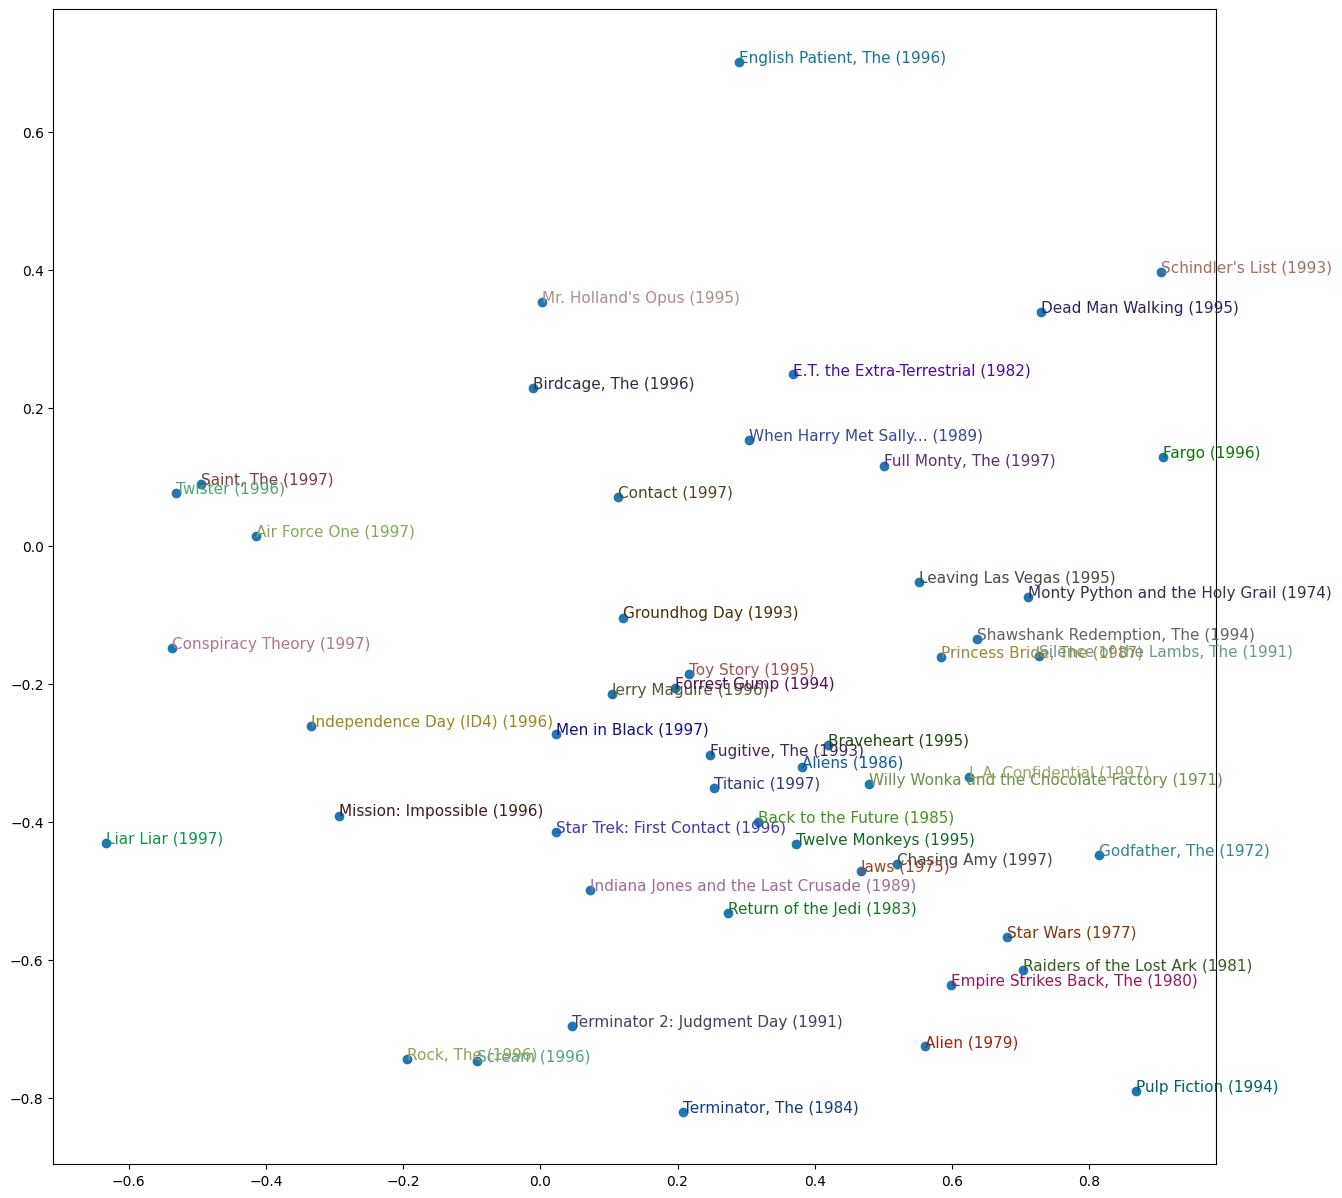

In [61]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

In [62]:

!pip install scikit-surprise







     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 10.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Operation cancelled by user


# Exercise 2

## Play around with different collaborative filtering model parameters such as n_factors and other parameters.
## Identify if any such parameters have impact on the speed of convergence or the performance on the model

In [63]:
!pip install scikit-surprise


  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505185 sha256=fd04bc38cafe16de3772bc22d5652cedf89af1af51082018f77b230a18bad07d
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [64]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# Step 1: Generate Synthetic Dataset
np.random.seed(42)

n_users = 100  # Number of users
n_movies = 50  # Number of movies
n_ratings = 1000  # Number of ratings

user_ids = np.random.randint(1, n_users + 1, n_ratings)
movie_ids = np.random.randint(1, n_movies + 1, n_ratings)
ratings = np.random.randint(1, 6, n_ratings)  # Ratings between 1 and 5

df = pd.DataFrame({'userId': user_ids, 'movieId': movie_ids, 'rating': ratings})

# Step 2: Load Data into Surprise Format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# Step 3: Train-Test Split
trainset, testset = train_test_split(data, test_size=0.2)

# Step 4: Train the SVD Model
model = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02)  # Tune these hyperparameters
model.fit(trainset)

# Step 5: Make Predictions
predictions = model.test(testset)

# Step 6: Evaluate Model
rmse = accuracy.rmse(predictions)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Step 7: Recommend Top Movies for a User
user_id = 5  # Example user
all_movie_ids = df['movieId'].unique()
rated_movies = df[df['userId'] == user_id]['movieId'].tolist()
unrated_movies = [movie for movie in all_movie_ids if movie not in rated_movies]

# Predict ratings for unrated movies
predicted_ratings = [(movie, model.predict(user_id, movie).est) for movie in unrated_movies]
top_recommendations = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 Recommended Movies for User 5:")
for movie, rating in top_recommendations:
    print(f"Movie ID {movie} - Predicted Rating: {rating:.2f}")


RMSE: 1.5928
Root Mean Squared Error (RMSE): 1.5928109012309113

Top 10 Recommended Movies for User 5:
Movie ID 4 - Predicted Rating: 3.91
Movie ID 23 - Predicted Rating: 3.79
Movie ID 34 - Predicted Rating: 3.72
Movie ID 32 - Predicted Rating: 3.69
Movie ID 15 - Predicted Rating: 3.66
Movie ID 25 - Predicted Rating: 3.60
Movie ID 49 - Predicted Rating: 3.58
Movie ID 30 - Predicted Rating: 3.56
Movie ID 5 - Predicted Rating: 3.56
Movie ID 37 - Predicted Rating: 3.50


In [65]:
import pandas as pd
import numpy as np
import time
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Generate a sample dataset
ratings_dict = {
    "userID": [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5, 6, 6, 7, 7, 8, 8, 9],
    "itemID": [1, 2, 3, 2, 3, 1, 2, 4, 1, 5, 2, 3, 5, 1, 4, 2, 3, 1, 5, 4],
    "rating": [4, 5, 3, 4, 2, 5, 3, 4, 2, 4, 5, 3, 1, 2, 4, 5, 3, 4, 2, 5],
}

df = pd.DataFrame(ratings_dict)

# Define Reader and Load Data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

# Split Data into Train and Test Sets
trainset, testset = train_test_split(data, test_size=0.2)

# List of different SVD parameter configurations to test
parameter_tests = [
    {"n_factors": 50, "n_epochs": 20, "lr_all": 0.005, "reg_all": 0.02},  # Default
    {"n_factors": 10, "n_epochs": 10, "lr_all": 0.005, "reg_all": 0.02},  # Faster convergence
    {"n_factors": 100, "n_epochs": 30, "lr_all": 0.007, "reg_all": 0.1},  # More complex
    {"n_factors": 200, "n_epochs": 50, "lr_all": 0.002, "reg_all": 0.05},  # Slowest, highest accuracy
]

# Track results
results = []

for params in parameter_tests:
    print(f"\nTraining with params: {params}")
    start_time = time.time()

    model = SVD(n_factors=params["n_factors"],
                n_epochs=params["n_epochs"],
                lr_all=params["lr_all"],
                reg_all=params["reg_all"])

    model.fit(trainset)
    predictions = model.test(testset)

    # Calculate RMSE (Root Mean Square Error)
    rmse = accuracy.rmse(predictions, verbose=True)
    end_time = time.time()
    time_taken = end_time - start_time

    results.append({"params": params, "RMSE": rmse, "Time Taken": time_taken})

# Display Results
results_df = pd.DataFrame(results)
print("\nSummary of results:")
print(results_df)



Training with params: {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}
RMSE: 1.2217

Training with params: {'n_factors': 10, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.02}
RMSE: 1.1432

Training with params: {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.007, 'reg_all': 0.1}
RMSE: 1.1846

Training with params: {'n_factors': 200, 'n_epochs': 50, 'lr_all': 0.002, 'reg_all': 0.05}
RMSE: 1.1995

Summary of results:
                                                                 params  \
0   {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}   
1   {'n_factors': 10, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.02}   
2   {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.007, 'reg_all': 0.1}   
3  {'n_factors': 200, 'n_epochs': 50, 'lr_all': 0.002, 'reg_all': 0.05}   

       RMSE  Time Taken  
0  1.221729    0.000619  
1  1.143220    0.000282  
2  1.184596    0.000669  
3  1.199549    0.002831  
